# Evaluate Results
***
This notebook focusses on the actual inights and value of the model we have created.
* In **section 2** we demostrate a possible implementation of the model's predictive power for dynamic allocation of patients
* In **section 3** we look at Partial Dependence plots to investigate the key patterns behind our data
* In **section 5** we outline actions that could be taken based on our insights, generated during this project.

In [1]:
import numpy as np
import pandas as pd
import tables
from joblib import dump, load

from sklearn.metrics import confusion_matrix
from src.evaluate_model import analyse_result, feature_importance, feature_importance_plot

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

%load_ext autoreload
%autoreload 2

In [2]:
import graphviz
from graphviz import Source
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import display

In [224]:
from src.partial_dependence import ecdf, discrete_pdp, continuous_pdp, plot_continuous_pdp, plot_discrete_pdp, daily_pdp

## 1. Load model & data
***
Download our stored pre-trained model & and the pre-processed data.

In [14]:
# load the final model
clf = load('models/rf_opt_06814.joblib') 

In [15]:
# load the input data for this model
filename = 'data/no_shows_model.h5'
df = pd.read_hdf(filename)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110525
Data columns (total 39 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   age                           110526 non-null  int64   
 1   scholarship                   110526 non-null  int64   
 2   hipertension                  110526 non-null  int64   
 3   diabetes                      110526 non-null  int64   
 4   alcoholism                    110526 non-null  int64   
 5   handicap                      110526 non-null  category
 6   sms_received                  110526 non-null  int64   
 7   handicap_bin                  110526 non-null  int64   
 8   female                        110526 non-null  int64   
 9   scheduled_month               110526 non-null  int64   
 10  scheduled_week                110526 non-null  int64   
 11  scheduled_dom                 110526 non-null  int64   
 12  scheduled_hour                

In [74]:
# features used as input
model_features = [col for col in df.columns if col != 'no_show_bin']

## 2. Predictive Power
***
As we have seen, we have a model that can predict wether or not a user shows up to his appointment with 70% accuracy. How is this usefull?

Besides disecting the model to investigate the underlying patterns in the data, which we will do in the next section with Partial Dependency plots, we could also use its predictive power to - for example - optimise allocation.

Say for example that you schedule appointments per 30 minutes, based on available doctors. If there are 5 doctors, we can schedule 5 appointments per 30 minutes, 10 per hour and 80 per day given an 8h workday. 

Given our model, we can estimate the probability of a no-show within a time-window and - given a threshold no-show probability - allocate an extra patient to this time-window (similar to overbooking on an aircraft). For non-emergency situations, for example admit some people in the waiting room as backup, but tell them to go away if it's unlikely they'll be helped soon, or give an estimated wait-time for non-scheduled visitors.

We only have appointment data per day, hence we will use that as time-window. Furthermore, we use Bayes Rule to calculate the no-show probability for a user given the model's accuracy (specificity/sensitivity).

**Bayes Rule applied**:

* $P(A|B) = \frac{P(B|A)\cdot P(A)}{P(B|A)\cdot P(A) + P(B|A^*)\cdot P(A^*)}$

* $P(no-show|pred-no-show) = \frac{P(pred-no-show|no-show)\cdot P(no-show)}{P(pred-no-show|no-show)\cdot P(no-show) + P(pred-no-show|show-up)\cdot P(show-up)}$

Here, we can find:
* $P(no-show|pred-no-show)$ as the **posterior**; the desired probability of a no-show given a predicted no-show by our model.
* $P(pred-no-show|no-show)$ as the model's **sensitivity** (recall) 
* $P(pred-no-show|show-up)$ as the model's 1 - **specificity**
* $P(no-show)$ as **prior**, the output of the model with $P(show-up) = 1 - P(no-show)$

In [258]:
def bayes_rule(prior, sensitivity, specificity):
    numerator = sensitivity*prior
    denominator = sensitivity*prior + (1-specificity)*(1-prior)
    return numerator/denominator

#### 2.1 select a time-window (day)
Appointment data is given by day (no timeslots), so we randomly choose Tuesday 17th May 2016 as our base set for this 'experiment'.

In [259]:
# at random - select Tuesday 17th May 2016
subset = df[(df['appointment_dom'] == 17) &
            (df['appointment_month'] == 5)].reset_index(drop=True)

subset.shape

(4372, 39)

In [260]:
subset['no_show_bin'].mean()

0.21386093321134492

In [261]:
subset.groupby('no_show_bin').size()

no_show_bin
0    3437
1     935
dtype: int64

#### 2.2 our model
Apply our model (created in the last notebook) to get the prior (our prediction / measurement), and use knowledge on the model statistics to calculate our posterior (probability of no show given our prediction of a no-show)

In [262]:
# no-show probability from our model (row specific)
subset['model_prior'] = clf.predict_proba(subset[model_features])[:,1]

In [263]:
# metrics on our model (see notebook 3_Modelling > opt dataframe)
sensitivity = 0.651451
specificity = 0.711346
subset['model_posterior'] = bayes_rule(subset['model_prior'], sensitivity, specificity)
subset['model_posterior'].head()

0    0.790943
1    0.796886
2    0.615562
3    0.921679
4    0.299494
Name: model_posterior, dtype: float64

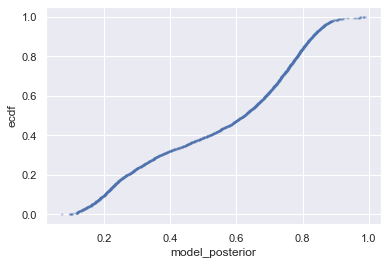

In [264]:
x,y = ecdf(subset['model_posterior'])
plt.scatter(x,y, s=2, alpha = 0.1)
plt.xlabel('model_posterior')
plt.ylabel('ecdf');

#### 2.3 result
We assume that currently there are no overbookings.

We manipulate the theshold probability above which we assume a user is a no-show, and we measure our performance.

In [265]:
subset.groupby('no_show_bin').size()

no_show_bin
0    3437
1     935
dtype: int64

> We've helped 3,437 patients and stood idle for 935 appointments

In [276]:
# single plot function we can re-use multiple times
def plot_model_performance(ax, x_ar, extra, overbooked, idle, xlabel, ylabel, title, x_min, x_max):
    ax.plot(x_ar, extra, label = 'extra patients helped')
    ax.plot(x_ar, overbooked, label = 'overbooked patients')
    ax.plot(x_ar, idle, label = 'idle appointments')

    ax.axhline(100, c='orange', linestyle = '--', label = 'control overbookings')
    ax.axhline(935, c='green', linestyle = '--', label = 'base-line no-shows')

    ax.set_xlim(x_min,x_max)
    ax.set_ylim(0,1500)

    ax.legend()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title);

In [277]:
model_extra = []
model_overbooked = []
model_idle = []
cutoff = []

for i in range(100):
    i = (i+1)/100
    cutoff.append(i)
    subset['model_backup'] = (subset['model_posterior'] > i)*1
    model_extra.append(subset[(subset['model_backup'] == 1) & (subset['no_show_bin'] == 1)].shape[0]) #extra helped
    model_overbooked.append(subset[(subset['model_backup'] == 1) & (subset['no_show_bin'] == 0)].shape[0]) #overbooked
    model_idle.append(subset[(subset['model_backup'] == 0) & (subset['no_show_bin'] == 1)].shape[0]) #idle

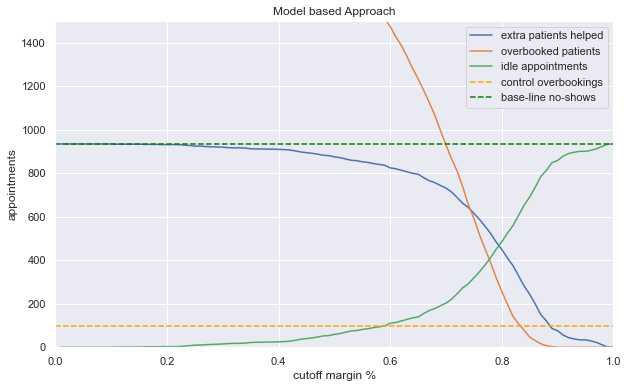

In [278]:
fig, ax = plt.subplots(figsize = (10,6))
plot_model_performance(ax, cutoff, model_extra, model_overbooked, model_idle,  
                       'cutoff margin %','appointments','Model based Approach', 0, 1)
plt.savefig('screenshot_2.png');

In [279]:
# control parameter - max overbooked
indx = np.where(np.array(model_overbooked) < 100)[0].min()
print('cutoff: ', cutoff[indx])
print('overbooked: ',model_overbooked[indx])
print('extra: ',model_extra[indx])
print('idle:', model_idle[indx])
print('allocation improvement: ', model_extra[indx]/935)

cutoff:  0.84
overbooked:  78
extra:  282
idle: 653
allocation improvement:  0.3016042780748663


#### 2.4 Discussion
For our target date (16/5/2016), we currently have helped 3,437 patients (appointments), and stood idle for 935 appointments (no-shows). We consider this our baseline appointment.

Any approached to correct this, consider 'overbooking' patients to counter no-shows. As control parameter we choose **overbookings**: patients we book extra that we cannot help, which we set at 100 appointments (2.3% daily total).

Using this control parameter for our model, we get a cutoff metric of 0.84 (meaning: if we get a posterior probability > 0.84 we schedule a backup), and we can help 282 extra users, a reduction of missed appointments by 30%.

> NOTE: when we developped the model, we aimed for a good capture of the patterns in the data, and decided to optimised F1-score and AUC. A result of this is a drop in accuracy, and more notable a decine in Precision (increase in False Postives). The latter is something we can see in the plot above, where we very quickly have overbookings.

> A next step would be to optimise the model specifically for allocation inprovement as above!

## 3. Partial Dependence Plots
***
With an overall accuracy of 93%, we have a model that provides a good representation of the patterns in the data. 

Comparing with the work done during the EDA, our model does take into account correlations between the various features. Whereas and Random Forrest an sich is not as easy to interpret as i.e. (Logistic) Regression, there are several methods for interpretation.

I use Partial Dependece Plots, where we fix a feature to one of it's values and assess the model output holding all other features constant. It's an easu to follow method, that's flexible and easy to manually manipulate (although their are python packages available for end-to-end solutions).

Other options to get model insights would be SHAP and LIME.

> Note: we use our own (re-purposes) code for this, see `src.partial_dependence.py`

#### 3.1 Check the top features

In [69]:
f_imp = feature_importance(df[model_features], clf)
f_imp.head()

,feature,importance
0,wait_time,0.259194
1,age,0.128553
2,scheduled_hour,0.0690307
3,scheduled_week,0.0636382
4,scheduled_dom,0.0523206


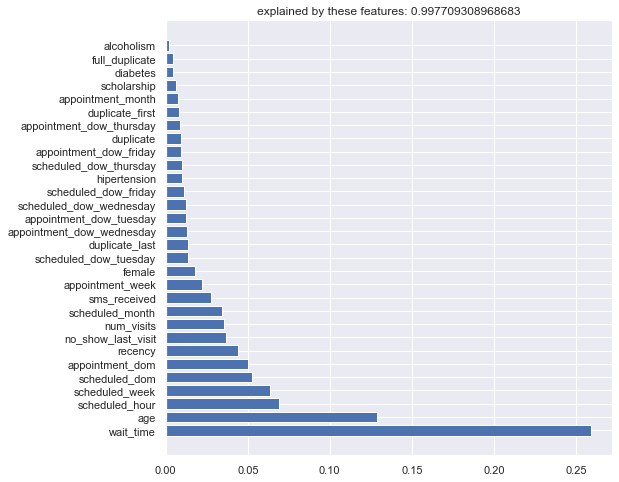

In [70]:
feature_importance_plot(f_imp, cutoff = 0.002, figsize = (8,8))

In [118]:
# check untill 'female'

#### 3.2  analyse `wait_time`
As this is the first PDP plot we're doing a brief explanation of the plots.

To analyse the patterns captured by the model, we focuss on two aspects:
* the no-show rate (predicted) for a given feature value
* the population % (appointment-count) that have this feature value (filter our edge-cases, which are defintely not irrelevant, but have less impact on the overall result).

The combination of these two aspects allows us to get an idea of the actual impact of a feature on the overall result.

In our plots, the first plot shows the actual Partial Dependence Plot. To generate this we take our dataset an fix a feature-column a specific feature value (holding all else equal) and use the model to predict and output (no_show_bin). We then calculate the no-show rate (mean of the binary predicted column) and move on to the next feature-value. 

In the second plot, we show an ECDF (Empirical Cumulative Distribution Function), which shows on the x-axis the same feature-values as the same plot, and on the y-axis the rate (%/100) of appointments with a feature value equal-to or smaller than this value. The ECDF is to some extend an alternative to a histogram, where you don't have the bin-bias issue.

In [71]:
df['wait_time'].describe()

count    110526.000000
mean          9.532825
std          15.027769
min           0.000000
25%           0.000000
50%           3.000000
75%          14.000000
max         178.000000
Name: wait_time, dtype: float64

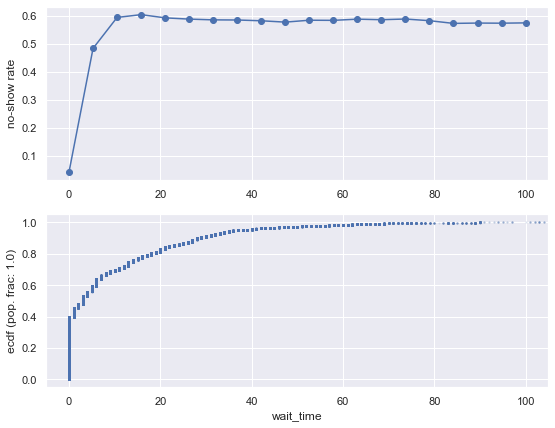

In [144]:
plot_continuous_pdp(clf, df[model_features], col = 'wait_time', n = 20, val_range = [0,100])

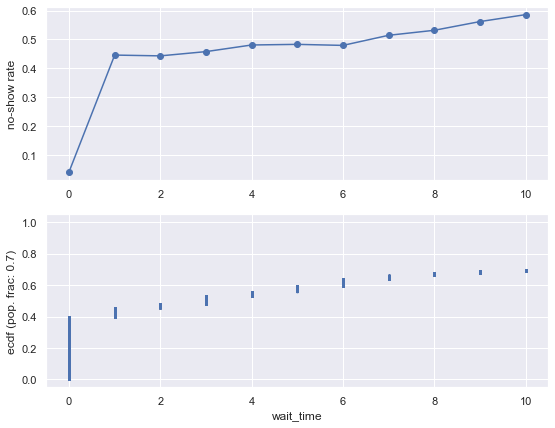

In [145]:
plot_continuous_pdp(clf, df[model_features], col = 'wait_time', n = 11, val_range = [0,10])

> Similar result for the EDA. Same day appointments show substantially lower no-show rate, as soon as you have to wait, it jumps up. The duration you have to wait (if it's more than 0 days), has less impact, although we see a slight increase in no_show_rate till 10 days before it stabilises.

#### 3.3 `age`

In [99]:
# guess on wait_time range
df['age'].describe()

count    110526.000000
mean         37.089219
std          23.110026
min           0.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: age, dtype: float64

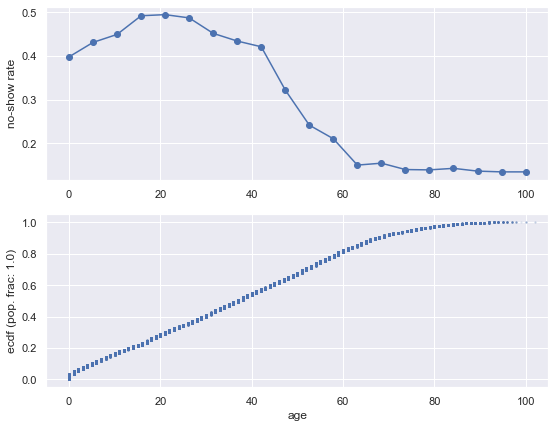

In [135]:
plot_continuous_pdp(clf, df[model_features], col = 'age', n = 20, val_range = [0,100])

> For age, we see a stronger pattern as during the EDA. No-show rate drops between an age of 40-60. Hypothesis here would be that no-show rate is high for the working population, potentially struggling to get time-off to visit the clinic.

#### 3.4 `scheduled` time
Covering `scheduled_hour`, `scheduled_week`, `scheduled_dow` and `scheduled_month`

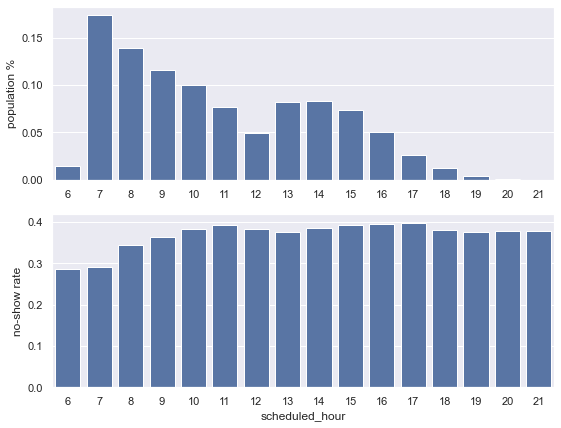

In [172]:
plot_discrete_pdp(clf, df[model_features], col = 'scheduled_hour')

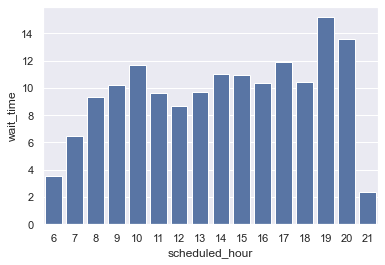

In [235]:
sns.barplot(data = df.groupby('scheduled_hour')['wait_time'].mean().reset_index(), 
            x = 'scheduled_hour', y = 'wait_time', color = sns.color_palette()[0]);

> interesting pattern here: early scheduled appointments (by hour, i.e. 6-7 am) have a lower no-show rate. A quick check also reveales that these hours also have the lowest wait-time (often same-day appointment). Intuitively this make sense: as the day progresses, there is not much chance to schedule an appointment on the same day.

> this does also raise the question: what determines the scheduling. I.e. are 'urgent' cases scheduled quicker? Early calls could also imply some urgency.

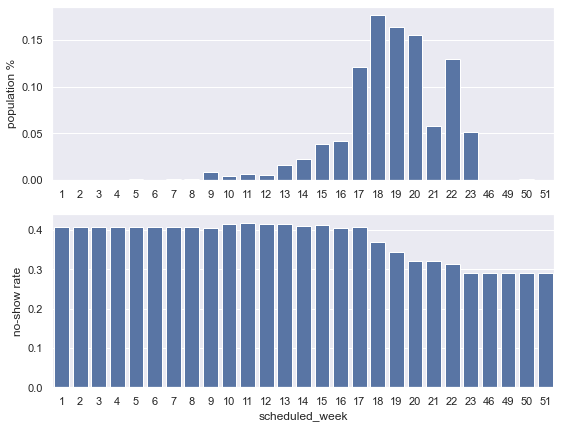

In [236]:
plot_discrete_pdp(clf, df[model_features], col = 'scheduled_week')

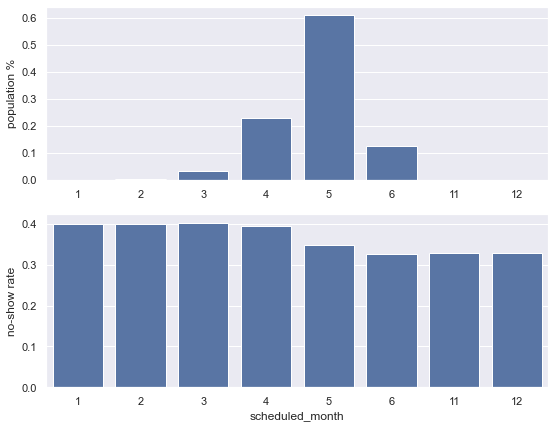

In [170]:
plot_discrete_pdp(clf, df[model_features], col = 'scheduled_month')

> Week and month show a similar pattern: no-show drops after the 5th month. Since we're only looking at appointments for the 5th months this makes sense and says more about the cut of the dataset we have then it does about the no-show of patients.

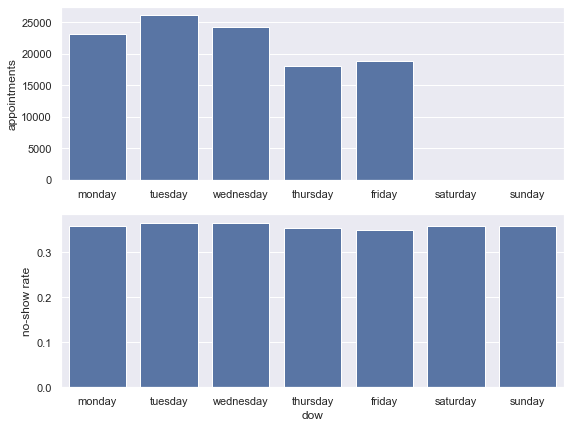

In [227]:
daily_pdp(clf, df[model_features], 'scheduled_dow')

> Day-of-week where the appointment is scheduled has little impact on the no-show rate; as expected from EDA as well. 

> For this PDP we've created a custom function, as we used dummy variables to encode the day-of-week. Initial cause for this is the usage of the name of the day during the EDA; for modelling and the PDP encoding the day-of-week as integers (0-6) would have been easier...

#### 3.5 RFM metrics
Covering `recency`, `no_show_last_visit` and `num_visits`

In [239]:
df['recency'].describe()

count    110526.000000
mean          3.692100
std           7.160498
min           0.000000
25%           0.000000
50%           0.000000
75%           5.000000
max          40.000000
Name: recency, dtype: float64

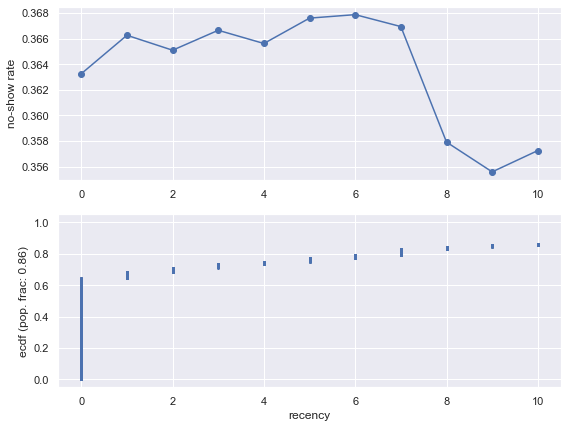

In [240]:
plot_continuous_pdp(clf, df[model_features], col = 'recency', n = 11, val_range = [0,10])

> Recency of visits (time since last visit) has little impact (note: y-range of no-show-rate is ~0.01). Also keep in mind that if we only have one visit of a user (which is the case for 56% of user), we have recency=0 by default.

> In addition, we have only 1 month of data, hence recency is limited.

In [241]:
df['num_visits'].describe()

count    110526.000000
mean          2.270326
std           3.913435
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          88.000000
Name: num_visits, dtype: float64

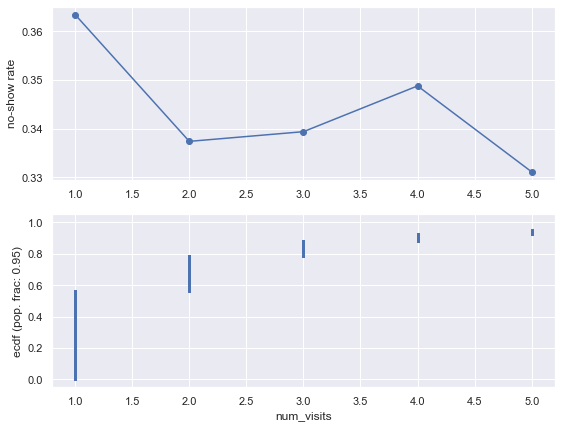

In [242]:
plot_continuous_pdp(clf, df[model_features], col = 'num_visits', n = 5, val_range = [1,5])

> multiple visits does drop the no-show rate a bit.

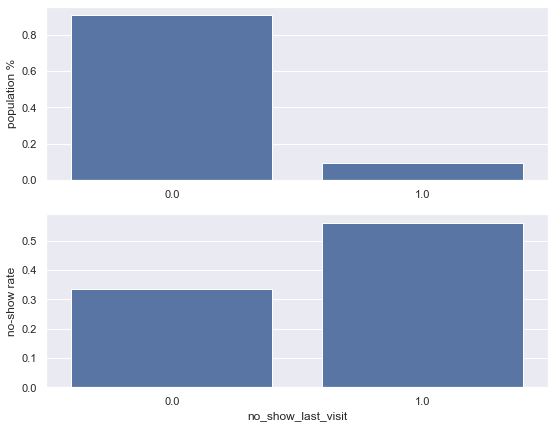

In [237]:
plot_discrete_pdp(clf, df[model_features], col = 'no_show_last_visit')

> No-show for the last visits is indeed an indication for no-show this visit, as expected from our EDA. More data for RFM could empower this feature more (or, debunk it).

#### 3.6 `sms_received`

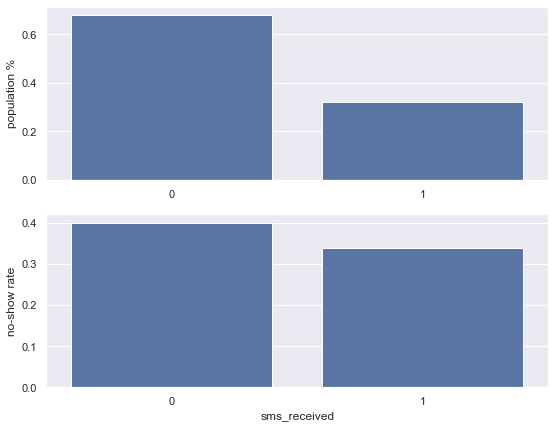

In [197]:
plot_discrete_pdp(clf, df[model_features], col = 'sms_received')

### 3.7 appointment time

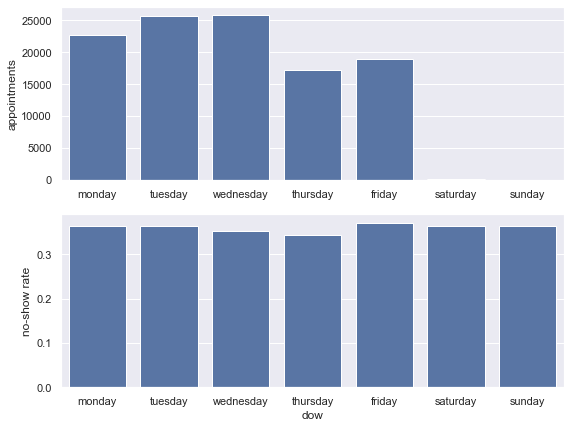

In [222]:
daily_pdp(df, 'appointment_dow')

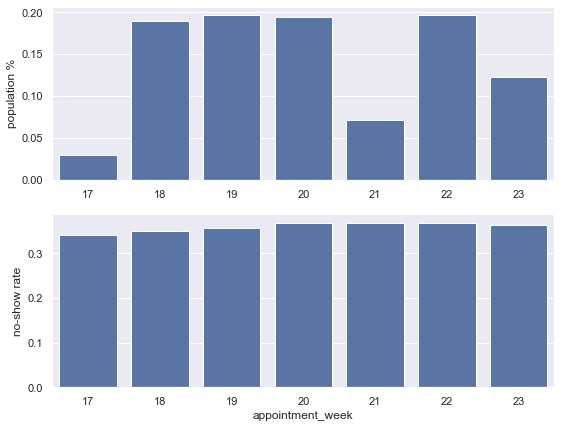

In [243]:
plot_discrete_pdp(clf, df[model_features], col = 'appointment_week')

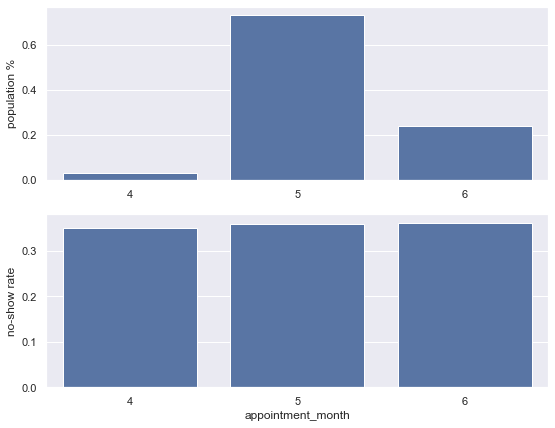

In [244]:
plot_discrete_pdp(clf, df[model_features], col = 'appointment_month')

> no major impact of when the appointment occurs on no-show-rate. Note that we do not have hourly data for appointments.

## 4. Segmentation
***
Using a Decision Tree, can we get a quick glance at some of the most relevant groups?

#### 4.1 two levels

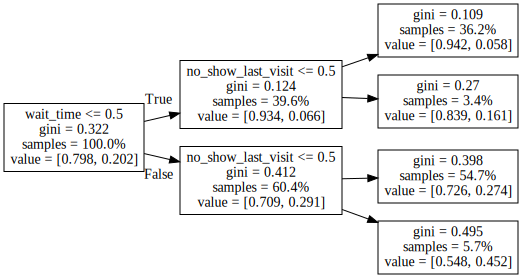

In [254]:
tree = DecisionTreeClassifier(max_depth=2)
tree.fit(df[model_features], df['no_show_bin'])

#visualize it
dot_graph = export_graphviz(tree, out_file=None, feature_names=model_features, proportion=True, rotate=True)
display(graphviz.Source(dot_graph))

> As expected, wait-time seems to be a key indicator. Also no surprise to see `no-show-last-visit` here as second row. Whereas the clinic staff could influence the `wait-time` (not easy though...), the `no-show-last-visit` is a lagging indicator and cannot be tweaked easily. 

> More research into the latter would be interesting. We've seen before that there are some duplicate schedulings, where our hypothesis is that this has been i.e. and adjustment (re-schedule). Potentially some of these previous no-shows are rescheduled appointments, where a second hypothesis could hint towards users being more likely to forget re-scheduled appointments.

#### 4.2 three levels

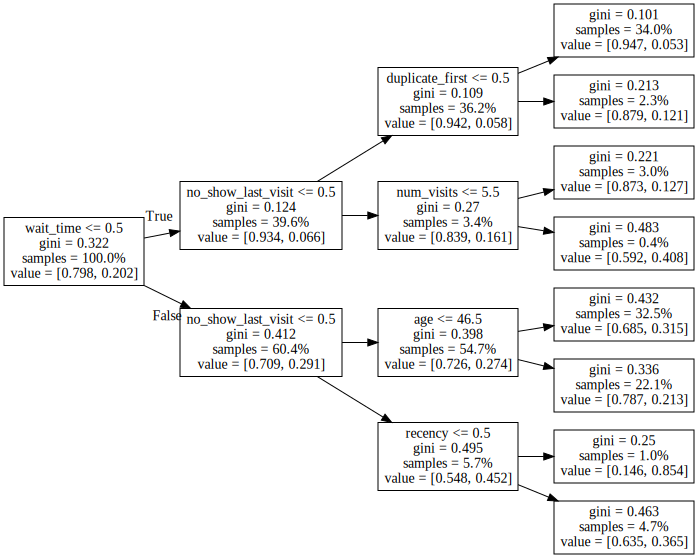

In [253]:
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(df[model_features], df['no_show_bin'])

#visualize it
dot_graph = export_graphviz(tree, out_file=None, feature_names=model_features, proportion=True, rotate=True)
display(graphviz.Source(dot_graph))

> expaning it to three levels reveals the expected `age` feature (<= 46.5 less likely to show-up), but more interstingly is the fact that 'duplicate_first' appointment shows-up (see EDA for explanation). We see that the fist appointment of a duplicate is less likely to be visited than the second appointment, which could hint towards rescheduling of this first appointment.

## 5. Overall Result
***
The objective of this project was: understand if a patient is coming to his doctors appointment, and use this to recommend strategic actions to increase the number of patients showing up.

What are our key learning and recomendations!?

#### 5.1 Context
After going through the data intesively with our EDA & modelling, we have identified some areas where we would like to know more context around the data.
* We've seen dome duplicates in patient_id + appointment_day (with difference appointment_id). We would like to know what's the background behing this? Are these appointments that are rescheduled (the first created effectively cancelled), or are these two separate appointments on the same day?
* Extending on the duplicates from the case above, we would like to know what happens when a user cancels his appointment. Are these excluded from the list? In that case, the no-show is 'expected'.
* On of the most valuable features proved to be the wait-time. We're interested to know what is the driver behind scheduling. For example, are urgent cases scheduled with a shorter wait-time (expected)? In that case, urgency would be the key driver for show-up, wait-time would be a result of planning with urgency in mind.
* Extending on the urgency, a backround to nature of the appointment would be valuable. Is it a check-up (annual), or an 'emergency' visit, or a check-up after a treatment (i.e. come back after one month). To this end, the nature of the clinic (what treatments are done would already help).
* At this point, appointment_day has daily granularity. Are appointments also scheduled on a daily basis, or per hour? 
* If appointments are scheduled by day - or by bigger time-slots - users are likely to have to wait at the clinic a well. In this case, when are users logged as no-show? The example I'm hinting towards is a user showing up for his appointment, seeing that the waiting room if full an deciding to go back home.

#### 5.2 Data
Extending on the context mentioned above, additional data that would be valuable:
* Low granularity appointment_day data (i.e. to the hour) - if available.
* If this data contains cancellations, can we annotate this?
* Most valuable would be a to get more data, i.e. from an entire year opposed to 1 month. We've seen that the RFM metrics are quite valuable, data over a longer period of time would improve these metrics and allow for better assessment of i.e. recurring visits (monthly checkup) within a closed cohort.
* Extending on the last case in 5.1, if there is a wait-time at the clinic as well, how long do we estimate it to be (if we cannot measure it, get quantitative estimate from the staff).

#### 5.3 Predictions
In section 2 we have shows that using our model, we can reduce no-shows by 30% by carefull overbooking of patients. Based on the assumption that there is a granular appointment allocation (i.e. a 30 min slot), this could integrated into a planning tool for staff. 

We do note that there are improvements possible to the existing model (improve precision).

#### 5.4 Strategic Actions
Some actions that the clinic could take to improve patients showing up for their appointments:
* **AGE:** We've seen that people >46 years of age as less likely to show-up for their appointment than older people. One hypothesis is that this is because these people have day-jobs (where the elderly are retired) preventing them from coming to their appointment. If we can show that this is the case, it might be worth to see if we can shift the opening hours of the clinic. I.e. cut morning attendance, and shift some personel to keep the clinic open on evenings and weekends.
* **WAIT-TIME:** given that there is a 20% no-show rate, it might be possible to schedule more patients on the same day (overbook), increasing the probability that they'll show-up. An improved predictive model as outlined in section 2 of this notebook could be used here (overbook appointments). Information from the last points in section 5.1 and 5.2 (wait-time at clinic) could be used as well.
* **SMS-received:** SMS's are only send to users that have an appointments scheduled >1 day in advance. Whilst they have a positive effect on reducing no-shows in this group, it is not very big. It would be worth to assess:
    * If the SMS is cost effective. I.e. do the costs of the SMS service outweigh the benefits of the reduced idle time of staff.
    * If the above is the case, an A/B test could be done to assess if it's worth extending the SMS service to lower wait-times (1 day wait-time, potentially even same-day appointments) as a reminder few hours before the appointment. If this research has not already been done...